# **1章: Rabi振動の観測**

本チュートリアルでは、Rabi 振動の観測実験の手順を解説します。
なお、本チュートリアルは、[第0章](../0_Setup/quel1.ipynb)の内容の理解を前提に進めます。

## **事前準備**

実験を行う事前準備を行います。
[第0章の 2.2 リンクアップ](../0_Setup/quel1.ipynb#subsection2)で実施した作業と同様に、ライブラリのインポート、制御装置のステータス確認、ポート周波数の確認をします。

また、使用方法によっては、`failed to acquire lock of 10.5.0.73` のエラーメッセージが表示される場合があります。
その際は、[第0章の 2.2 リンクアップ](../0_Setup/quel1.ipynb#subsection2)でエラーの概要と対処方法を解説しているので、必要に応じて参照してください。

In [1]:
import warnings

warnings.filterwarnings("ignore")

from pprint import pprint

import numpy as np
from common.qexp_func_rabi import *

# キュエル社から提供するライブラリ
from e7awghal import AwgParam, CapParam, CapSection, WaveChunk
from IPython.display import clear_output
from quel_ic_config import Quel1Box, Quel1BoxType, force_unlock_all_boxes

In [2]:
BOX_CONFIG = {
    "ipaddr_wss": "10.1.0.73",
    "boxtype": Quel1BoxType.fromstr("quel1-a"),
}

force_unlock_all_boxes()  # boxを再作成する場合に、古いboxが握っているロックの解除を確実にする

# Boxオブジェクトの作成と初期化
box = Quel1Box.create(**BOX_CONFIG)

# 制御装置とホストの通信確立
execute_linkup = False
if execute_linkup:
    print("Box is being linked up...")
    status = box.relinkup()
else:
    status = box.reconnect()

# リンクアップの状態を確認
if all(status.values()):
    print("Box is ready to use.")
else:
    print("Box is not linked up. Please execute relinkup.")

Box is ready to use.


### **各ポートの周波数設定**

Rabi 振動の実験で使用する各ポートの周波数設定を行います。
本チュートリアルでは、制御装置の 3 つのポートを使用します。
これらのポートは下図に示すように、超伝導量子ビットおよび読み出し共振器と接続します。
- 量子ビットの制御用信号: port 9
- 読み出し共振器
  - 受信: port 0
  - 送信: port 1

量子ビットおよび読み出し共振器の共振周波数は、事前に CW 測定等で既知となっていることを前提として、以下のコードでポートの周波数設定を行います。
本チュートリアルで使用する量子ビットとその読み出し共振器の情報は以下の通りです。

量子ビットおよび読み出し共振器の共振周波数を設定します。
CW 測定等で事前に測定した実際の周波数を使用してください。
初期状態では、以下に示す仮の値をコードに埋め込んであります。
上書きしてご使用ください。

- 量子ビット共振周波数: 8500.00 MHz
- 読み出し共振周波数: 10200.00 MHz

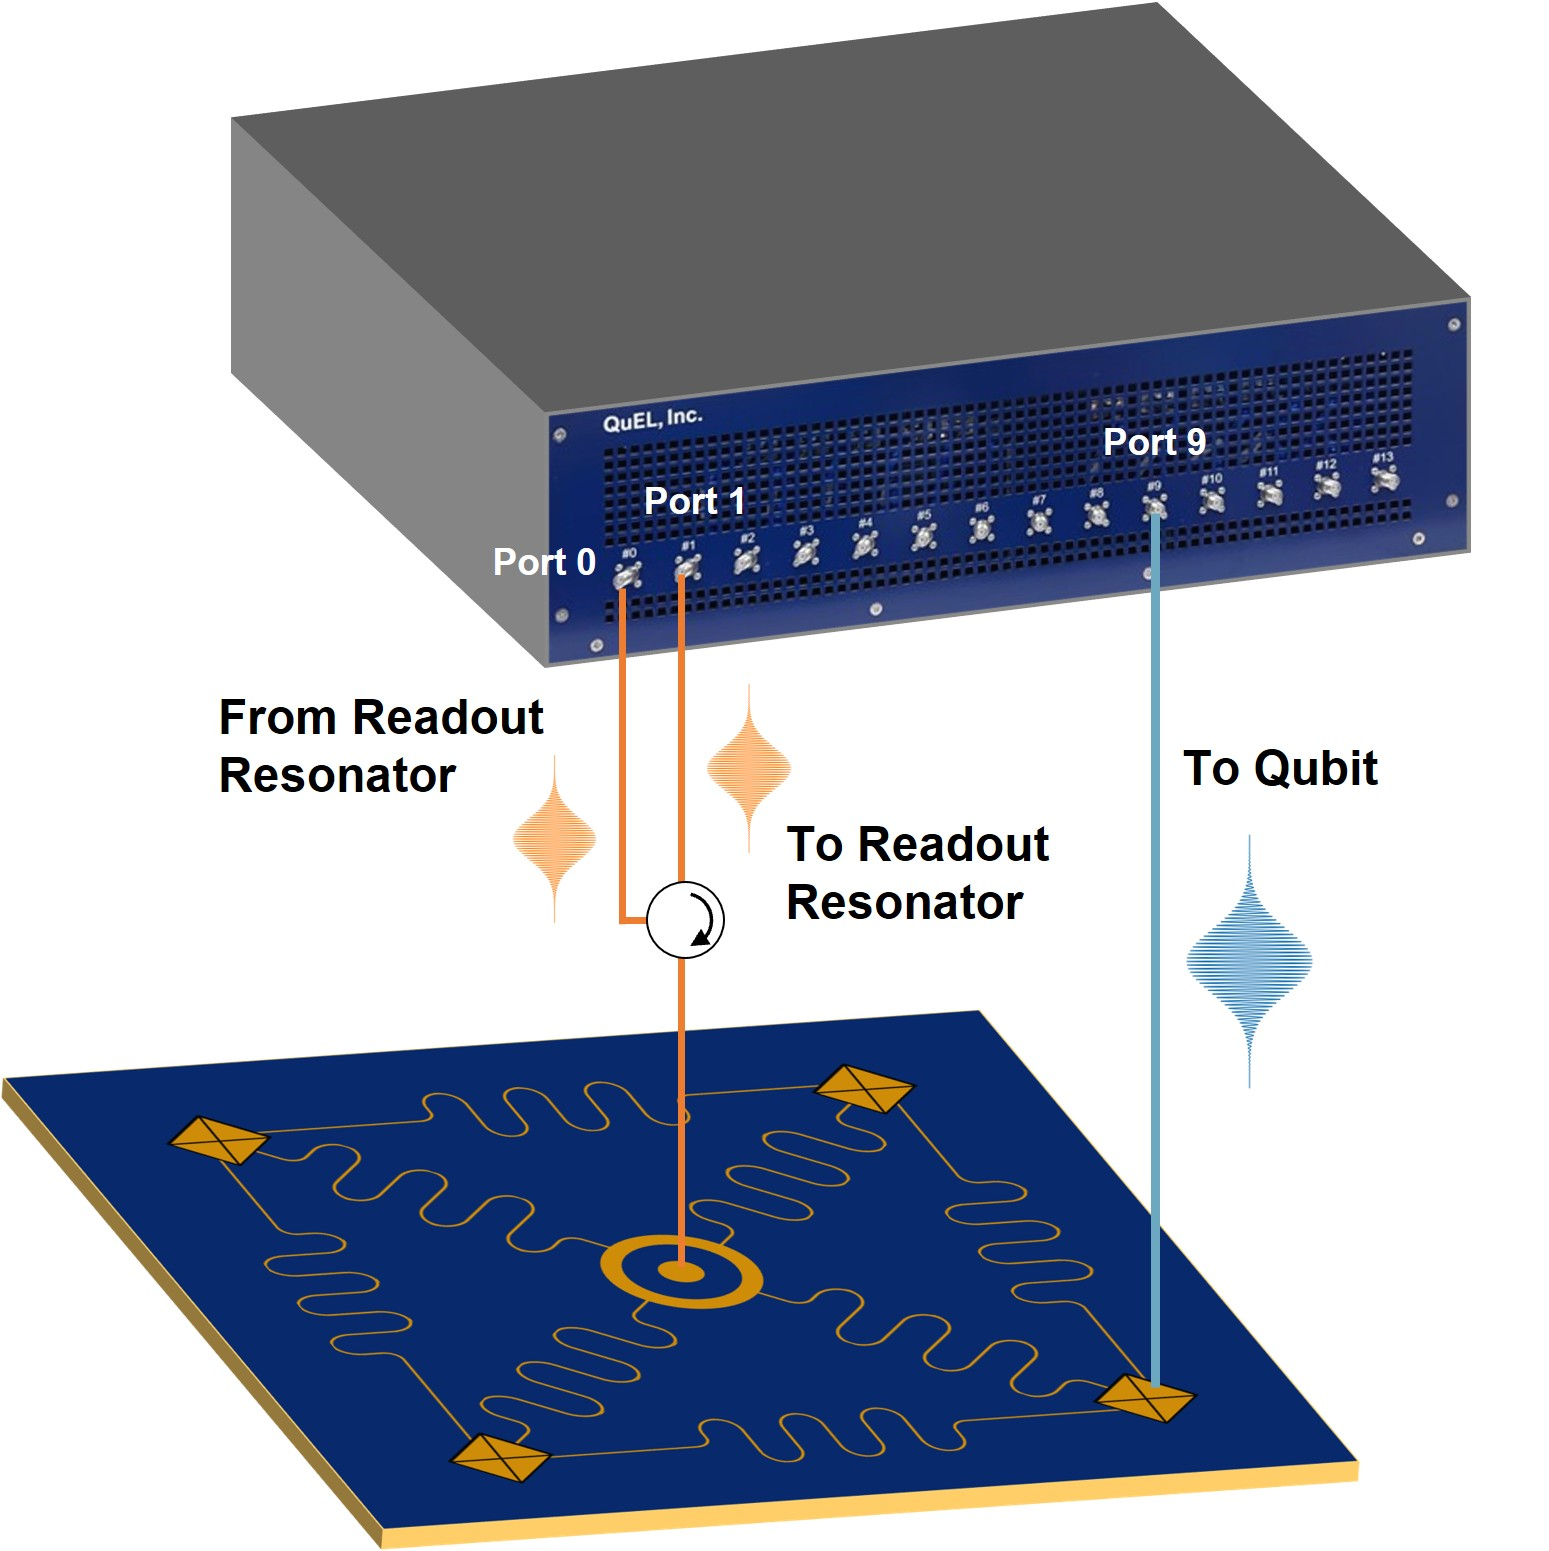

In [3]:
from IPython.display import Image

Image("figs/rabi_exp_config.jpg")

In [4]:
freq_ctrl = 8500.00e6  # 量子ビット制御用マイクロ波パルスの周波数 [Hz]
freq_ro = 10200.000e6  # 読み出し用マイクロ波パルスの周波数 [Hz]

上記で設定した所望の周波数を出力するための各種パラメタを設定します。
制御装置における信号生成の原理などは、[第0章](../0_Setup/quel1.ipynb)の内容を参照してください。
本チュートリアルでは、所望のマイクロ波パルスの周波数を出力するための、LO, NCO, および AWG の設定を自動で計算する関数を `qexp_func_rabi.py` 内に用意しています。

In [5]:
# アナログミキサ出力のサイドバンドの設定
sideband_ctrl = "L"  # 制御LO と NCO の差周波でダウンコンバート
sideband_ro = "U"  # LO と NCO の差周波でアップコンバート

# LO, NCO, AWG の周波数を計算
freq_ctrl_lo, freq_ctrl_nco, freq_ctrl_awg = frequency_calc_ctrl(freq_ctrl, sideband_ctrl)
freq_ro_lo, freq_ro_nco = frequency_calc_ro(freq_ro, sideband_ro)
freq_ro_awg = frequency_calc_ro_awg(freq_ro, freq_ro_lo, freq_ro_nco, sideband_ro)

print("Ctrl[LO, NCO, AWG]: ", freq_ctrl_lo, freq_ctrl_nco, freq_ctrl_awg)
print("RO[LO, NCO, AWG]: ", freq_ro_lo, freq_ro_nco, freq_ro_awg)

Ctrl[LO, NCO, AWG]:  11500000000 3000000000 0.0
RO[LO, NCO, AWG]:  8000000000 2203125000 -3125000.0


LO の周波数の設定に関して注意点があります。
[第0章](../0_Setup/quel1.ipynb)で説明したように、LO 信号は、信号生成のアナログアップ(ダウン)コンバージョンのミキサに入力します。
この時、ミキサの出力には、所望信号だけでなく、ミキサの出力に漏れ出た LO 信号も存在します。
この不要な LO 信号成分は、適切なフィルタで除去できます。
[こちら](../model/quel1.md)で説明したように、QuEL-1 の制御出力信号ポートおよび観測信号出力ポートのフィルタの帯域は、それぞれ 7-10 GHz と 9.5-11 GHz です。
不要な LO 信号による量子ビット制御への影響を抑えたい場合は、これらのフィルタ帯域外に LO の周波数を設定する必要があります。

上記のセルで得られた周波数情報を用いて、以下のようにポート設定します。

In [ ]:
# 各ポートの周波数設定
# read-out
box.config_port(
    port=1,
    lo_freq=freq_ro_lo,
    cnco_freq=freq_ro_nco,
    sideband=sideband_ro,
    vatt=0x800,
    rfswitch="pass",
)
# read-in
box.config_port(
    port=0,
    cnco_locked_with=1,
    rfswitch="open",
)
# ctrl
ctrl_port = 9
box.config_port(
    port=ctrl_port,
    lo_freq=freq_ctrl_lo,
    cnco_freq=freq_ctrl_nco,
    sideband=sideband_ctrl,
    vatt=0x800,
    rfswitch="pass",
)

# ポート設定の確認
pprint(box.dump_box()["ports"])

## **Rabi 振動測定**

### **パルスシーケンスの設定**

Rabi 振動測定に必要なパルスシーケンスの設定を行います。
制御パルスと読み出しパルスの両方の設定が必要です。
まず、パルスシーケンスの定義に必要な時間のパラメータを定義します。
本チュートリアルでは、`t_u = 128 [ns]` を単位として、その整数倍でそれぞれの時間のパラメータを指定します。
`t_u = 128 [ns]` を単位とするのは、使用しているファームウェアによる制約であり、波形データの設定は、64 サンプル (= 128 ns) の倍数で設定します。


In [7]:
t_u = 128  # 時間の基本パラメータ
time_ctrl = t_u * 10  # 制御出力の送信区間 (128 ns の倍数で指定)
time_ro = t_u * 12  # 読み出し出力の送信時間 (128 ns の倍数で指定)
time_margin = t_u * 2  # 読み出し開始から読み出し出力終了までの時間差 (128 ns の倍数で指定)
time_interval = t_u * 1024  # 128 ns の倍数で指定

#### **量子ビット制御用パルスの設定**

量子ビット制御用パルスは、立上がりと立下りが 10 ns の raised-cosine flat top パルスを使用します (`raised_cosine_flat_top_pulse`)。
量子ビット制御用のパルスシーケンスは、以下のセルで `wave_ctrl` として定義します。

#### **読み出し用のパルスの設定**

読み出し用のパルスは矩形波パルス (`square_pulse`) を用います。
読み出し用のパルスシーケンスは、以下のセルで `wave_ro` として定義します。

In [ ]:
# 制御パルス幅のリスト (ns)
ampl_ctrl = 0.03  # 量子ビット制御用マイクロ波パルスの振幅
rise_time = 10  # 本実験では raise time 10 ns の raised-cosine flat top パルスを使用
ctrl_pulse_width_list = np.arange(0, 150, 5)

# 繰り返し設定
num_repeats = 100
cp = CapParam(
    num_repeat=num_repeats,
    integration_enable=True,
    num_wait_word=(time_ctrl + time_margin) // 2 // 4,
)  # 2 ns / sample,  4 sample /word
cp.sections.append(
    CapSection(
        name="s0",
        num_capture_word=(time_ro + 6 * time_margin) // 2 // 4,
        num_blank_word=(time_ctrl - 2 * time_margin + time_interval) // 2 // 4,
    )
)  # 2 ns / sample,  4 sample /word

# 読み出しシーケンスの設定
ro_ampl = 0.1  # 読み出し用マイクロ波パルスの振幅
wave_ro = square_pulse(
    time_ctrl // 2,
    time_ro // 2,
    (time_margin * 4 + time_interval) // 2,
    amplitude=ro_ampl,
)  # 長さ time_ro // 2 のパルス前後に blank を挿入
wave_ro_awg = awg_output(wave_ro, freq_ro_awg, phase=0)  # 読み出しパルスの AWG 出力
box.config_runit(port=0, runit=0, capture_param=cp)  # ポート 0 の runit 0 に設定
# 生成した読み出し用のマイクロ波パルスの iq データを AWG に登録
box.register_wavedata(port=1, channel=0, name="ro", iq=wave_ro_awg)
awg_param_ro = AwgParam(num_repeat=num_repeats)
awg_param_ro.chunks.append(WaveChunk(name_of_wavedata="ro", num_repeat=num_repeats))

iq_sum_list = []

# パルス時間を掃引
for index, ctrl_pulse_width in enumerate(ctrl_pulse_width_list):
    # 制御パルス定義
    wave_rcft = raised_cosine_flat_top_pulse(ctrl_pulse_width, rise_time, amplitude=ampl_ctrl)
    arbit_ctrl = embed_array(time_ctrl // 2, wave_rcft)  # 時間基準を読み出しの開始に合わせる
    blank_ctrl = np.zeros((time_ro + time_margin * 4 + time_interval) // 2, dtype=np.complex64)
    wave_ctrl = np.concatenate((arbit_ctrl, blank_ctrl))
    wave_ctrl_awg = awg_output(wave_ctrl, freq_ctrl_awg)  # AWG 出力

    # 生成したiqデータを AWG に登録
    box.register_wavedata(port=ctrl_port, channel=0, name="ctrl", iq=wave_ctrl_awg)
    awg_param_ctrl = AwgParam(num_repeat=num_repeats)
    awg_param_ctrl.chunks.append(WaveChunk(name_of_wavedata="ctrl", num_repeat=num_repeats))

    # 波形パラメタを AWG に入力
    box.config_channel(
        port=1,
        channel=0,
        awg_param=awg_param_ro,
    )
    box.config_channel(
        port=ctrl_port,
        channel=0,
        awg_param=awg_param_ctrl,
    )

    # 出力と読み出しを0.1秒後に一斉に開始
    cur = box.get_current_timecounter()
    thunk_ri, thunk_ro = box.start_capture_by_awg_trigger(
        {(0, 0)},
        {(1, 0), (ctrl_port, 0)},
        cur + 125_000_000 // 10,  # 時刻カウンタ周波数 125MHz x 0.1s = 12_500_000
    )

    # 出力終了を確認
    thunk_ro.result()

    iqs_ri_readers = thunk_ri.result()
    iqs_ri = iqs_ri_readers[0, 0].as_wave_dict()["s0"]
    iq_ri = iqs_ri[0]

    # デモジュレーション
    iq_demod_ri = demodulate(iq_ri, freq_ro_awg)

    # 移動平均を取る
    avg_num = 100
    weight = np.ones(avg_num) / avg_num  # フラットな重みでの移動平均。ここで任意のFIRフィルタを設定可能
    mov_avg_iq = np.convolve(iq_demod_ri, weight, mode="same")

    n_s = 400
    n_f = 1300
    # mov_avg_iq array の n_s 番目から n_f 番目までの積分を取り、1点の複素数を計算
    iq_sum_list.append(np.sum(mov_avg_iq[n_s:n_f]) / len(mov_avg_iq[n_s:n_f]))

    plot_iq_ns(
        mov_avg_iq,
        np.max(abs(mov_avg_iq)) * 1.2,
        f"Filtered Wave: width={ctrl_pulse_width} ns",
    )
    plot_iq_ns(
        mov_avg_iq[n_s:n_f],
        np.max(abs(mov_avg_iq[n_s:n_f])) * 1.2,
        f"Filtered Wave: width={ctrl_pulse_width} ns",
    )

    plot_iq_scatter_marker(
        np.array(iq_sum_list, dtype=np.complex64),
        np.max(abs(iq_sum_list[0])) * 1.2,
        "Rabi Oscillation",
        markersize=10,
        figsize=(4, 4),
    )
    clear_output(wait=True)


# 結果を numpy array として保存
iq_sum = np.array(iq_sum_list, dtype=np.complex64)

### **Rabi振動測定結果の表示**

得られた IQ 値をプロットし、フィッティングを行うことで Rabi 周波数を求めます。
ここでは、 IQ データを $x$ 軸に対して垂直になるように回転させ、以下の関数で Q 成分に対してフィッティングを行います。

$$
A e^{-t/\tau}\cos(2\pi ft + \phi) + B
$$


In [ ]:
# IQ に対する複素数平面での直線フィッティング
# 最小二乗法で直線フィッティング
A = np.vstack([iq_sum.real, np.ones(len(iq_sum))]).T
slope, section = np.linalg.lstsq(A, iq_sum.imag, rcond=None)[0]

# IQ 値を回転させてx軸に垂直にする
theta_fit = np.arctan(slope)  # 傾きを用いて回転角度を計算
theta_rotation = np.pi / 2 - theta_fit  # x軸に垂直にするための回転角度を計算
iq_rot = iq_sum * np.exp(1j * theta_rotation)  # IQ値を回転
if np.mean(iq_rot.real) < 0:  # 平均が負の場合はさらに180度回転
    iq_rot *= np.exp(1j * np.pi)

# 回転前後の結果を図示
plot_iq_rot_scatter_marker(
    iq_sum,
    iq_rot,
    np.max(abs(iq_rot)),
    "Rabi Oscillation",
    markersize=5,
    figsize=(4, 4),
)

# 回転後のQ値を正規化してフィッティングを行う
fitting_result = rabi_fitting(ctrl_pulse_width_list, iq_rot, "Rabi Oscillation", figsize=(8, 4))
print(f"Rabi frequency: {fitting_result[2]*1.e3:.2f} MHz")

### **Chevron パターン**

量子ビット制御用パルスの周波数とパルス幅を掃引しながら Rabi 振動を観測することで Chevron パターンを取得し、マイクロ波パルス照射下における量子ビットの共振周波数を求めます。

In [ ]:
# 制御パルス幅のリスト (ns)
ctrl_pulse_width_list = np.arange(0, 150, 5)

# 周波数の掃引範囲を設定 [MHz]
freq_list = np.linspace(-20, 20, 11)
freq_center = freq_ctrl  # 中心周波数を設定
chevron_pattern = np.array([])  # 結果を格納する配列

# 周波数を掃引
for index_freq, freq_diff in enumerate(freq_list):
    print(f"\n {freq_diff} MHz: ", end=" ")

    iq_sum_list_1d = []

    # パルス時間を掃引
    for index_pulse, ctrl_pulse_width in enumerate(ctrl_pulse_width_list):
        print(f"{ctrl_pulse_width}ns", end=" ", flush=True)

        # 制御パルス定義
        wave_rcft = raised_cosine_flat_top_pulse(ctrl_pulse_width, rise_time, amplitude=ampl_ctrl)
        arbit_ctrl = embed_array(time_ctrl // 2, wave_rcft)  # 時間基準を読み出しの開始に合わせる
        blank_ctrl = np.zeros((time_ro + time_margin * 4 + time_interval) // 2, dtype=np.complex64)
        wave_ctrl = np.concatenate((arbit_ctrl, blank_ctrl))
        wave_ctrl_awg = awg_output(wave_ctrl, freq_ctrl_awg + freq_diff * 1e6)  # AWG 出力: 周波数掃引

        # 生成したiqデータを AWG に登録
        box.register_wavedata(port=ctrl_port, channel=0, name="ctrl", iq=wave_ctrl_awg)
        awg_param_ctrl = AwgParam(num_repeat=num_repeats)
        awg_param_ctrl.chunks.append(WaveChunk(name_of_wavedata="ctrl", num_repeat=num_repeats))

        # 波形パラメタを AWG に入力
        box.config_channel(
            port=1,
            channel=0,
            awg_param=awg_param_ro,
        )
        box.config_channel(
            port=ctrl_port,
            channel=0,
            awg_param=awg_param_ctrl,
        )

        # 出力と読み出しを0.1秒後に一斉に開始
        cur = box.get_current_timecounter()
        thunk_ri, thunk_ro = box.start_capture_by_awg_trigger(
            {(0, 0)},
            {(1, 0), (ctrl_port, 0)},
            cur + 125_000_000 // 10,
        )

        # 出力終了を確認
        thunk_ro.result()

        iqs_ri_readers = thunk_ri.result()
        iqs_ri = iqs_ri_readers[0, 0].as_wave_dict()["s0"]
        iq_ri = iqs_ri[0]

        # デモジュレーション
        iq_demod_ri = demodulate(iq_ri, freq_ro_awg)

        # 移動平均を取る
        mov_avg_iq = np.convolve(iq_demod_ri, weight, mode="same")

        # mov_avg_iq array の n_s 番目から n_f 番目までの積分を取り、1点の複素数を計算
        iq_sum_list_1d.append(np.sum(mov_avg_iq[n_s:n_f]) / len(mov_avg_iq[n_s:n_f]))

    iq_sum_1d = np.array(iq_sum_list_1d, dtype=np.complex64)

    # IQ に対する複素数平面での直線フィッティング
    A = np.vstack([iq_sum_1d.real, np.ones(len(iq_sum_1d))]).T
    slope, section = np.linalg.lstsq(A, iq_sum_1d.imag, rcond=None)[0]

    # IQ 値を回転させてx軸に垂直にする
    theta_fit = np.arctan(slope)
    theta_rotation = np.pi / 2 - theta_fit
    iq_rot_1d = iq_sum_1d * np.exp(1j * theta_rotation)
    if np.mean(iq_rot_1d.real) < 0:
        iq_rot_1d *= np.exp(1j * np.pi)

    chevron_pattern = np.append(chevron_pattern, iq_rot_1d.imag)

In [ ]:
# Chevron パターンの表示
chevron_pattern = chevron_pattern.reshape(len(freq_list), len(ctrl_pulse_width_list))
plot_chevron_pattern(chevron_pattern, ctrl_pulse_width_list, freq_list + freq_center * 1.0e-6, (12, 8))

Cheveron パターンからマイクロ波パルス照射下における量子ビットの共鳴周波数を求めていきます。
得られた Chevron パターンに対してフーリエ変換を行い、Rabi 振動の周波数が最小となる量子ビット制御用マイクロ波の周波数を、マイクロ波パルス照射下における量子ビットの共鳴周波数として採用します。

In [ ]:
z_fourier = []
dt = ctrl_pulse_width_list[1] - ctrl_pulse_width_list[0]
nf = 2**8

# 各データ行に対してフーリエ変換を実行
for signal in chevron_pattern:
    zero_filled_signal = np.append(signal - np.average(signal), np.zeros(nf - len(signal)))
    z_fourier_ = np.abs(np.fft.fft(zero_filled_signal))
    z_fourier.append(z_fourier_[: int(len(z_fourier_) / 2)])

freq = np.linspace(0, 1e3 / (2 * dt), int(len(zero_filled_signal) / 2))

plot_fft_pattern(np.array(z_fourier), freq, freq_list + freq_center * 1.0e-6, (12, 8))

In [ ]:
Rabi_freq_MHz = []

for i in range(len(z_fourier)):
    max_index = np.argmax(z_fourier[i])
    Rabi_freq_MHz.append(freq[max_index])

fitting_result2 = plot_rabi_freq(freq_list + freq_center * 1.0e-6, Rabi_freq_MHz, "", figsize=(8, 4))
print(f"Resonant frequency: {fitting_result2[1]:.2f} MHz")

## **制御装置の解放** 

実験が終了したら制御装置のロックを解放します。
ロックを解放しないと、他のノートブックから制御装置へのアクセスができません。

In [17]:
force_unlock_all_boxes()

### **バージョン確認**

In [6]:
import quel_ic_config

quel_ic_config.__version__

'0.10.1rc1'